In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [ ]:
import datetime
import os

In [ ]:
#start = datetime.now()

# if os.path.isfile('data.csv'):
#     os.remove('data.csv')

if not os.path.isfile('data1.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data1.csv', mode='w')
    
    row = list()
    files=['../content/gdrive/MyDrive/Colab Notebooks/netflix/combined_data_1.txt','../content/gdrive/MyDrive/Colab Notebooks/netflix/combined_data_2.txt', 
           '../content/gdrive/MyDrive/Colab Notebooks/netflix/combined_data_3.txt', '../content/gdrive/MyDrive/Colab Notebooks/netflix/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
#print('Time taken :', datetime.datetime.now() - start)

Reading ratings from ../content/gdrive/MyDrive/Colab Notebooks/netflix/combined_data_1.txt...
Done.

Reading ratings from ../content/gdrive/MyDrive/Colab Notebooks/netflix/combined_data_2.txt...
Done.

Reading ratings from ../content/gdrive/MyDrive/Colab Notebooks/netflix/combined_data_3.txt...
Done.

Reading ratings from ../content/gdrive/MyDrive/Colab Notebooks/netflix/combined_data_4.txt...
Done.



In [ ]:
print("creating the dataframe from data1.csv file..")
df = pd.read_csv('data1.csv', sep=',', names=['movie_id', 'user_id','rating','date']).sample(n=400000)
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data1.csv file..
Done.

Sorting the dataframe by date..
Done..


In [ ]:
df.head()

,movie_id,user_id,rating,date
46313774,8327,905467,3,1999-12-28
50506754,9112,2226276,3,1999-12-30
70686823,12818,1723352,2,1999-12-30
81205625,14590,471064,2,1999-12-31
21357199,3970,472452,3,1999-12-31


In [ ]:
df.groupby('rating')['rating'].sum()

rating
1     18267
2     80666
3    343281
4    538300
5    461990
Name: rating, dtype: int64

In [ ]:
count_nan =  df.groupby('rating')['rating'].agg(['count'])
count_nan

,count
rating,
1,18267
2,40333
3,114427
4,134575
5,92398


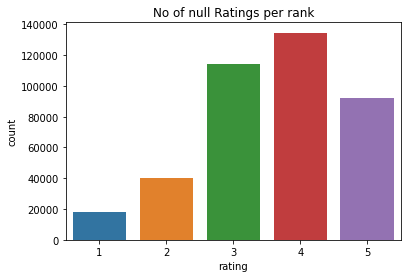

In [ ]:
plt.title("No of null Ratings per rank")
sns.barplot(x = count_nan.index , y = count_nan['count'])
plt.show()

In [ ]:
df.dropna(inplace=True)

In [ ]:
column_names=['movie_id','year','title']
movie_titles = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/netflix/movie_titles.csv",sep=',', names=column_names,encoding='ISO-8859-1')


In [ ]:
movie_titles.head()


,movie_id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
movie_titles.isnull().sum()


movie_id    0
year        7
title       0
dtype: int64

In [ ]:

print("listing no of movies without years")
movie_titles[pd.isnull(movie_titles).any(axis =1 )]

listing no of movies without years


,movie_id,year,title
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


In [ ]:
movie_titles.at[4387,'year'] = 2001
movie_titles.at[4793,'year'] = 2001
movie_titles.at[7240,'year'] = 2001
movie_titles.at[10781,'year'] = 1974
movie_titles.at[15917,'year'] = 1999
movie_titles.at[16677,'year'] = 1994
movie_titles.at[17666,'year'] = 1999

In [ ]:
movie_titles.isnull().any()


movie_id    False
year        False
title       False
dtype: bool

In [ ]:
movie_titles.dtypes


movie_id      int64
year        float64
title        object
dtype: object

In [ ]:
df=df.merge(movie_titles, left_on='movie_id', right_on='movie_id')


In [ ]:
df.head()

,movie_id,user_id,rating,date,year,title
0,8327,905467,3,1999-12-28,1975.0,One Flew Over the Cuckoo's Nest
1,8327,1704412,4,2000-01-18,1975.0,One Flew Over the Cuckoo's Nest
2,8327,1685089,4,2000-01-25,1975.0,One Flew Over the Cuckoo's Nest
3,8327,2571175,5,2000-02-04,1975.0,One Flew Over the Cuckoo's Nest
4,8327,82662,4,2000-04-16,1975.0,One Flew Over the Cuckoo's Nest


In [ ]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()


title
NFL Super Bowl XXXVII                              5.0
Metallica: With the San Francisco Symphony: S&M    5.0
Suze Orman: The Road to Wealth                     5.0
David Searching                                    5.0
The Lost Boys: Special Edition: Bonus Material     5.0
Name: rating, dtype: float64

In [ ]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()


title
Miss Congeniality         900
The Patriot               854
The Godfather             829
Independence Day          807
The Day After Tomorrow    794
Name: rating, dtype: int64

In [ ]:

ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Allo 'Allo!: Series 1,4.0
'Allo 'Allo!: Series 3,3.0
'N Sync: 'N the Mix,3.0
'N Sync: Live at Madison Square Garden,4.0
'N Sync: Making of the Tour,3.0


In [ ]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Allo 'Allo!: Series 1,4.0,2
'Allo 'Allo!: Series 3,3.0,1
'N Sync: 'N the Mix,3.0,2
'N Sync: Live at Madison Square Garden,4.0,3
'N Sync: Making of the Tour,3.0,1


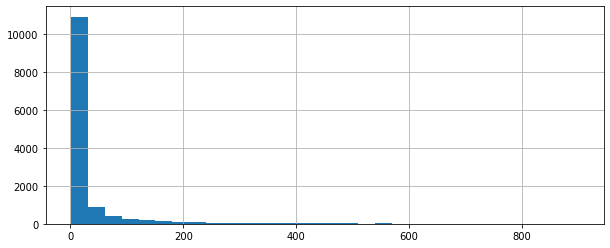

In [ ]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=30)
plt.show()


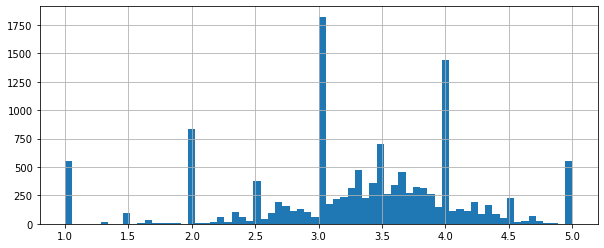

In [ ]:

plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

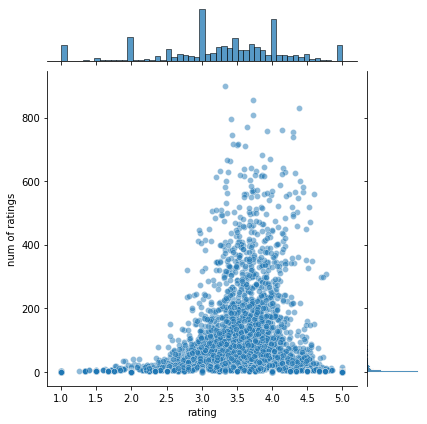

In [ ]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)


In [ ]:
imdb_file = '../content/gdrive/MyDrive/Colab Notebooks/imdb/IMDb movies.csv'

imdb_df = pd.read_csv(imdb_file)

imdb_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [ ]:
pd.merge(movie_titles, imdb_df, how = 'inner', left_on = 'title', right_on = 'title').shape


(4876, 24)

In [ ]:
# Sample top 1K users w/ top 10K movies
g = df.groupby('user_id')['rating'].count()
top_users = g.sort_values(ascending=False)[:1000]
g = df.groupby('movie_id')['rating'].count()
top_movies = g.sort_values(ascending=False)[:10000]
top_r = df.join(top_users, rsuffix='_r', how='inner', on='user_id')
df = top_r.join(top_movies, rsuffix='_r', how='inner', on='movie_id')


In [ ]:
# Encode the user and movie from 0 to distinct number of users / movies
user_enc = LabelEncoder()
df['user_enc'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user_enc'].nunique()
item_enc = LabelEncoder()
df['movie_enc'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie_enc'].nunique()
df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

In [ ]:
n_users, n_movies, min_rating, max_rating


(1000, 5659, 1.0, 5.0)

Embedding


In [ ]:
df

,movie_id,user_id,rating,date,year,title,rating_r,rating_r,user_enc,movie_enc
16,8327,1171523,4.0,2002-03-09,1975.0,One Flew Over the Cuckoo's Nest,10,343,447,2637
36,8327,265257,4.0,2002-07-21,1975.0,One Flew Over the Cuckoo's Nest,14,343,97,2637
37,8327,2283695,3.0,2002-08-19,1975.0,One Flew Over the Cuckoo's Nest,11,343,861,2637
106,8327,1418521,5.0,2004-05-20,1975.0,One Flew Over the Cuckoo's Nest,11,343,530,2637
129,8327,2150689,1.0,2004-08-09,1975.0,One Flew Over the Cuckoo's Nest,12,343,811,2637
...,...,...,...,...,...,...,...,...,...,...
244683,6374,654591,5.0,2005-01-20,2002.0,South Park: Ghouls,11,24,244,2004
266898,15365,2375169,3.0,2005-08-16,1991.0,Flight of the Intruder,11,17,896,4868
393725,7833,2375169,3.0,2005-11-11,2004.0,Arrested Development: Season 2,11,25,896,2486
221053,10413,1599816,3.0,2003-07-09,2002.0,Clockstoppers,10,37,604,3254


In [ ]:
X = df[['user_enc', 'movie_enc']].values
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11570, 2), (1286, 2), (11570,), (1286,))

In [ ]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
X_train_array

[array([535, 789, 948, ..., 942, 547, 229]),
 array([2256, 1431, 2412, ..., 1068, 4241, 2643])]

In [ ]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        50000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        282950      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
181/181 [==============================] - 18s 16ms/step - loss: 12.1242 - val_loss: 12.3056
Epoch 2/5
181/181 [==============================] - 3s 14ms/step - loss: 12.0342 - val_loss: 12.3053
Epoch 3/5
181/181 [==============================] - 3s 14ms/step - loss: 11.5784 - val_loss: 12.3045
Epoch 4/5
181/181 [==============================] - 3s 14ms/step - loss: 11.0776 - val_loss: 12.2997
Epoch 5/5
181/181 [==============================] - 2s 13ms/step - loss: 10.1753 - val_loss: 12.2922


In [ ]:
x

NameError: ignored

In [ ]:
# Get Embeddings for Movies
movie_layer = model.get_layer('embedding_1')
movie_weights = movie_layer.get_weights()[0]
# movie_weights[:10]
movie_weights_df = pd.DataFrame(movie_weights).reset_index()
movie_weights_df.rename(columns={'index':'movie_enc'}, inplace=True)


In [ ]:
movie_weights_df.head()


,movie_enc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.043691,-0.013777,0.086195,-0.081356,0.056196,-0.088241,0.065024,0.035200,0.097106,-0.038307,0.068024,-0.045379,-0.081011,-0.055961,0.071091,0.055147,0.058951,-0.065277,0.073195,-0.066289,0.039027,-0.044993,0.074100,0.063373,0.058762,0.086080,0.071680,-0.057540,-0.062648,-0.070320,-0.037128,0.047227,0.073495,-0.084647,-0.038082,-0.059576,-0.063834,-0.054333,0.017499,-0.053732,-0.056469,0.036868,-0.064415,-0.093668,-0.066042,-0.088206,0.092578,-0.059136,0.051821,0.004704
1,1,0.059996,0.078434,-0.086373,-0.048854,0.076460,-0.052970,0.066444,0.073601,-0.081532,0.072430,-0.036312,0.092168,-0.014161,-0.027793,-0.031619,0.073563,-0.091381,-0.080756,-0.081559,0.084300,-0.065494,0.055993,0.069965,-0.043258,0.004208,-0.090387,0.069343,0.068381,-0.037592,0.047892,-0.093679,0.030689,0.092712,0.049837,0.086031,0.075489,-0.052269,-0.069600,0.024482,-0.057502,-0.079722,0.056487,0.014331,0.072857,-0.033190,-0.056123,0.056328,-0.093360,0.065907,-0.059364
2,2,-0.062683,-0.094300,0.055946,0.072540,-0.038875,0.096794,0.028476,-0.004061,0.103747,-0.073815,-0.043984,-0.029075,-0.048258,-0.026235,0.086158,-0.039873,0.099120,-0.082565,-0.022071,0.056328,0.055118,-0.093970,-0.043942,0.080414,-0.089171,0.070259,0.038158,0.042739,0.037651,-0.039237,0.082662,0.033207,-0.077253,-0.063251,-0.007724,0.085372,0.081631,-0.080396,0.090998,0.067050,0.069556,0.057674,0.071169,-0.070427,0.059899,0.056761,0.053002,0.022385,0.046509,0.079763
3,3,0.079642,0.055858,-0.071883,-0.064006,0.088921,-0.095575,0.048023,0.056231,-0.076071,0.096595,-0.047954,0.075640,0.046977,0.071419,0.067221,-0.072252,0.080377,-0.055842,-0.061469,-0.077412,-0.093513,0.064272,0.099183,0.084293,-0.094342,-0.063860,0.063212,0.083703,0.065009,-0.071489,-0.078120,0.073449,0.069189,0.087890,0.056686,0.083933,-0.066796,-0.068924,0.088343,-0.059001,0.095216,0.071647,0.077981,0.082587,-0.070516,0.059019,-0.088867,-0.084956,0.072562,0.088051
4,4,0.077402,-0.067971,0.044632,0.076509,0.061657,0.072377,-0.063812,0.072518,-0.083655,0.096301,0.070331,0.074383,-0.080025,0.093859,0.078044,0.077809,0.083953,0.035850,-0.083521,-0.061158,-0.071767,-0.070321,-0.016887,0.084471,-0.084047,-0.075450,0.054732,0.055356,0.057841,-0.067883,0.047738,-0.054436,0.086381,-0.054917,-0.081786,-0.079017,-0.053924,0.068464,0.071502,0.084720,-0.073913,0.031989,0.069821,0.079048,-0.049424,-0.054028,-0.004166,-0.068756,0.052672,-0.076838


In [ ]:
# Get Movie to Titles Mapping
movie_list = df[['movie_enc','movie_id']].drop_duplicates()
movie_titles = movie_list.merge(movie_titles, left_on='movie_id', right_on='movie_id')
#movie_titles.head()

In [ ]:
# Append Titles to Embedding
movie_weights_titles_df = movie_weights_df.merge(movie_titles, left_on = 'movie_enc', right_on = 'movie_enc')
movie_weights_titles_df.head()

,movie_enc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,movie_id,year,title
0,0,-0.043691,-0.013777,0.086195,-0.081356,0.056196,-0.088241,0.065024,0.035200,0.097106,-0.038307,0.068024,-0.045379,-0.081011,-0.055961,0.071091,0.055147,0.058951,-0.065277,0.073195,-0.066289,0.039027,-0.044993,0.074100,0.063373,0.058762,0.086080,0.071680,-0.057540,-0.062648,-0.070320,-0.037128,0.047227,0.073495,-0.084647,-0.038082,-0.059576,-0.063834,-0.054333,0.017499,-0.053732,-0.056469,0.036868,-0.064415,-0.093668,-0.066042,-0.088206,0.092578,-0.059136,0.051821,0.004704,3,1997.0,Character
1,1,0.059996,0.078434,-0.086373,-0.048854,0.076460,-0.052970,0.066444,0.073601,-0.081532,0.072430,-0.036312,0.092168,-0.014161,-0.027793,-0.031619,0.073563,-0.091381,-0.080756,-0.081559,0.084300,-0.065494,0.055993,0.069965,-0.043258,0.004208,-0.090387,0.069343,0.068381,-0.037592,0.047892,-0.093679,0.030689,0.092712,0.049837,0.086031,0.075489,-0.052269,-0.069600,0.024482,-0.057502,-0.079722,0.056487,0.014331,0.072857,-0.033190,-0.056123,0.056328,-0.093360,0.065907,-0.059364,6,1997.0,Sick
2,2,-0.062683,-0.094300,0.055946,0.072540,-0.038875,0.096794,0.028476,-0.004061,0.103747,-0.073815,-0.043984,-0.029075,-0.048258,-0.026235,0.086158,-0.039873,0.099120,-0.082565,-0.022071,0.056328,0.055118,-0.093970,-0.043942,0.080414,-0.089171,0.070259,0.038158,0.042739,0.037651,-0.039237,0.082662,0.033207,-0.077253,-0.063251,-0.007724,0.085372,0.081631,-0.080396,0.090998,0.067050,0.069556,0.057674,0.071169,-0.070427,0.059899,0.056761,0.053002,0.022385,0.046509,0.079763,8,2004.0,What the #$*! Do We Know!?
3,3,0.079642,0.055858,-0.071883,-0.064006,0.088921,-0.095575,0.048023,0.056231,-0.076071,0.096595,-0.047954,0.075640,0.046977,0.071419,0.067221,-0.072252,0.080377,-0.055842,-0.061469,-0.077412,-0.093513,0.064272,0.099183,0.084293,-0.094342,-0.063860,0.063212,0.083703,0.065009,-0.071489,-0.078120,0.073449,0.069189,0.087890,0.056686,0.083933,-0.066796,-0.068924,0.088343,-0.059001,0.095216,0.071647,0.077981,0.082587,-0.070516,0.059019,-0.088867,-0.084956,0.072562,0.088051,16,1996.0,Screamers
4,4,0.077402,-0.067971,0.044632,0.076509,0.061657,0.072377,-0.063812,0.072518,-0.083655,0.096301,0.070331,0.074383,-0.080025,0.093859,0.078044,0.077809,0.083953,0.035850,-0.083521,-0.061158,-0.071767,-0.070321,-0.016887,0.084471,-0.084047,-0.075450,0.054732,0.055356,0.057841,-0.067883,0.047738,-0.054436,0.086381,-0.054917,-0.081786,-0.079017,-0.053924,0.068464,0.071502,0.084720,-0.073913,0.031989,0.069821,0.079048,-0.049424,-0.054028,-0.004166,-0.068756,0.052672,-0.076838,17,2005.0,7 Seconds


In [ ]:
top_movies


movie_id
5317     900
14313    816
15124    807
15205    794
1905     761
        ... 
1588       2
15488      2
15489      2
15502      2
1567       2
Name: rating, Length: 10000, dtype: int64

In [ ]:
movie_titles[movie_titles.movie_id == 4622]


,movie_enc,movie_id,year,title


In [ ]:
movie_weights_only_df = pd.DataFrame(movie_weights)


In [ ]:
# Calculate distances between the specific movie and all other movies
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

# the_movie_embedding_only_normalized = preprocessing.normalize(np.array(the_movie_embedding_only), norm='l2')
movie_weights_only_df.iloc[:,:] = Normalizer(norm='l2').fit_transform(movie_weights_only_df)
the_movie_embedding_only_normalized = movie_weights_only_df[movie_weights_only_df.index == 3499]
the_movie_dot_product_normalizer = movie_weights_only_df.dot(np.transpose(the_movie_embedding_only_normalized))

In [ ]:
recommendation=the_movie_dot_product_normalizer.sort_values(by = 3499, ascending = False).head(15)

In [ ]:
recommendation

,3499
3499,1.000000
2543,0.986769
5317,0.985783
910,0.985355
38,0.982156
2399,0.977723
822,0.964310
644,0.963340
4517,0.961406
3480,0.953721


In [ ]:
recommendation.index

Int64Index([3499, 2543, 5317,  910,   38, 2399,  822,  644, 4517, 3480, 5221,
            4877, 3575, 3068,  195],
           dtype='int64')

In [ ]:
# Get Movieid to Titles Mapping

recommendation_list =pd.DataFrame(recommendation.index,columns=['movie_id'])
recommendation_titles = recommendation_list.merge(movie_titles, left_on='movie_id', right_on='movie_id')

In [ ]:
recommendation_titles

,movie_id,movie_enc,year,title
0,5317,1669,2000.0,Miss Congeniality
1,38,13,2003.0,Daydream Obsession
2,822,256,2001.0,Star Trek: Enterprise: Season 1
3,4517,1422,1997.0,Mimic
4,3480,1094,1990.0,Narrow Margin
5,4877,1537,2004.0,Simpsons Gone Wild


**PCA**

In [ ]:
movie_genre = pd.merge(movie_titles, imdb_df, how = 'inner', left_on = 'title', right_on = 'title')
movie_genre_df = movie_genre[['movie_enc', 'movie_id', 'year_x', 'title', 'director', 'genre']]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
movie_weights_only_pca = pca.fit_transform(movie_weights_only_df)

In [ ]:
movie_weights_only_pca

array([[-0.11871163, -0.13888068],
       [ 0.17214124, -0.12674442],
       [-0.06813673, -0.25267398],
       ...,
       [ 0.23481002,  0.20236744],
       [-0.17797291,  0.14375664],
       [ 0.32973942,  0.24910417]], dtype=float32)

In [ ]:
pca.explained_variance_ratio_


array([0.03188389, 0.03095546], dtype=float32)

In [ ]:
movie_weights_only_pca_df = pd.DataFrame(movie_weights_only_pca)
movie_weights_only_pca_df = pd.DataFrame(movie_weights_only_pca_df).reset_index()
movie_weights_only_pca_df.rename(columns={'index':'movie_enc'}, inplace=True)

In [ ]:
movie_weights_only_pca_df


,movie_enc,0,1
0,0,-0.118712,-0.138881
1,1,0.172141,-0.126744
2,2,-0.068137,-0.252674
3,3,0.233650,-0.155160
4,4,0.212272,-0.004669
...,...,...,...
5654,5654,-0.018999,0.288551
5655,5655,-0.134860,0.170062
5656,5656,0.234810,0.202367
5657,5657,-0.177973,0.143757


In [ ]:
movie_genre = pd.merge(movie_titles, imdb_df, how = 'inner', left_on = 'title', right_on = 'title')
movie_genre_df = movie_genre[['movie_enc', 'movie_id', 'year_x', 'title', 'director', 'genre']]
# movie_genre_df.head()

In [ ]:
movie_pca_genre = movie_weights_only_pca_df.merge(movie_genre_df, left_on = 'movie_enc', right_on = 'movie_enc')

In [ ]:
movie_pca_genre.rename(columns={0:'pca_0'}, inplace=True)
movie_pca_genre.rename(columns={1:'pca_1'}, inplace=True)

In [ ]:
movie_pca_genre.head()


,movie_enc,pca_0,pca_1,movie_id,year_x,title,director,genre
0,1,0.172141,-0.126744,6,1997.0,Sick,Ryan M. Andrews,"Horror, Sci-Fi"
1,9,-0.205659,0.262043,26,2004.0,Never Die Alone,Ernest R. Dickerson,"Action, Crime, Drama"
2,17,-0.149915,-0.029919,55,1995.0,Jade,William Friedkin,"Crime, Drama, Thriller"
3,18,0.389500,0.059447,56,2004.0,Carandiru,Hector Babenco,"Drama, Crime"
4,19,-0.019003,0.092540,57,1995.0,Richard III,"André Calmettes, James Keane",Drama


In [ ]:
movie_pca_genre.groupby('genre').count()['movie_enc'].sort_values(ascending=False)
# movie_pca_genre.genre

genre
Drama                          151
Drama, Romance                  88
Comedy, Drama, Romance          82
Comedy                          64
Comedy, Drama                   61
                              ... 
Adventure, Horror, Mystery       1
Comedy, Family                   1
Adventure, Horror, Thriller      1
Adventure, Romance               1
Comedy, Mystery, Romance         1
Name: movie_enc, Length: 289, dtype: int64

In [ ]:
new = movie_pca_genre["genre"].str.split(", ", n = 1, expand = True)
movie_pca_genre['new_genre'] = new[0]
movie_pca_genre.head()

,movie_enc,pca_0,pca_1,movie_id,year_x,title,director,genre,new_genre
0,1,0.172141,-0.126744,6,1997.0,Sick,Ryan M. Andrews,"Horror, Sci-Fi",Horror
1,9,-0.205659,0.262043,26,2004.0,Never Die Alone,Ernest R. Dickerson,"Action, Crime, Drama",Action
2,17,-0.149915,-0.029919,55,1995.0,Jade,William Friedkin,"Crime, Drama, Thriller",Crime
3,18,0.389500,0.059447,56,2004.0,Carandiru,Hector Babenco,"Drama, Crime",Drama
4,19,-0.019003,0.092540,57,1995.0,Richard III,"André Calmettes, James Keane",Drama,Drama


In [ ]:

#sample_data = movie_pca_genre[movie_pca_genre.new_genre.isin(['Horror', 'Action', 'Musical','Drama','Thriller','Crime'])]
sample_data = movie_pca_genre[movie_pca_genre.new_genre.isin([ 'Crime','Horror'])]

In [ ]:
sample_data

,movie_enc,pca_0,pca_1,movie_id,year_x,title,director,genre,new_genre
0,1,0.172141,-0.126744,6,1997.0,Sick,Ryan M. Andrews,"Horror, Sci-Fi",Horror
2,17,-0.149915,-0.029919,55,1995.0,Jade,William Friedkin,"Crime, Drama, Thriller",Crime
11,36,-0.011892,0.072749,143,1997.0,The Game,Bill Rebane,Horror,Horror
20,81,0.114445,-0.084945,273,2004.0,Taxi,Roy Del Ruth,"Crime, Drama, Romance",Crime
21,81,0.114445,-0.084945,273,2004.0,Taxi,Carlos Saura,"Crime, Drama, Romance",Crime
...,...,...,...,...,...,...,...,...,...
1712,5556,0.116611,0.284872,17479,2002.0,The Ring,Hideo Nakata,"Horror, Mystery",Horror
1713,5556,0.116611,0.284872,17479,2002.0,The Ring,Gore Verbinski,"Horror, Mystery",Horror
1722,5589,0.025031,-0.187505,17563,1962.0,Lolita,Stanley Kubrick,"Crime, Drama, Romance",Crime
1727,5613,0.119778,-0.403477,17631,1964.0,Zulu,Jérôme Salle,"Crime, Drama, Thriller",Crime


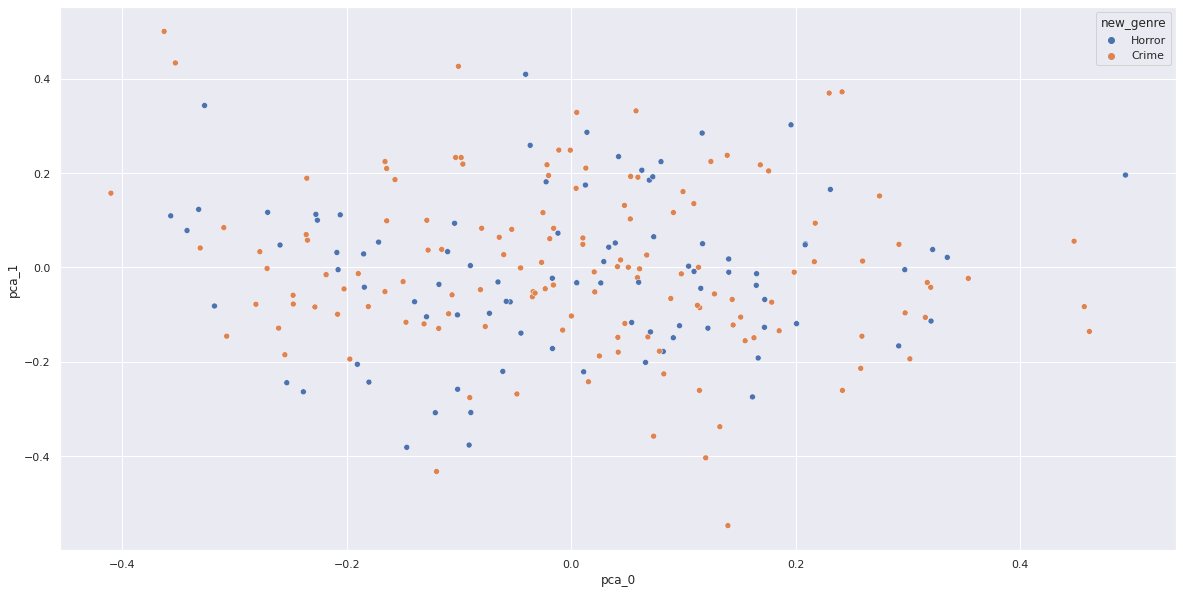

In [ ]:

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = movie_pca_genre['pca_0'], y = movie_pca_genre['pca_1'], hue = "new_genre", data = sample_data)